In [1]:
%load_ext autoreload

%autoreload 2

In [3]:
import os
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] \t %(message)s",
    datefmt="%b %d %Y %I:%M%p",
)

os.chdir("../")

In [147]:
from src import etl, utils
from src.rfm import *
import numpy as np
import matplotlib.pyplot as plt

In [6]:
logger.info("test")

Feb 22 2023 01:44AM [INFO] 	 test


In [7]:
# get current directory
os.getcwd()

'/home/arunavgupta/Documents/UCSD/ml-theory-capstone'

In [8]:
# get all urls to make all datasets
import re

def clean_url(x):
    search = re.findall(r'"(.*?)"', x)
    if search:
        return search[0]
    else:
        return ""

urls = list(filter(lambda x: len(x) > 0, map(clean_url, open("./src/urls.txt", "r").readlines())))

urls

['https://www.gutenberg.org/cache/epub/1533/pg1533-images.html',
 'https://www.gutenberg.org/cache/epub/27761/pg27761-images.html',
 'https://www.gutenberg.org/cache/epub/1112/pg1112.html',
 'https://www.gutenberg.org/cache/epub/1514/pg1514-images.html',
 'https://www.gutenberg.org/cache/epub/1531/pg1531-images.html',
 'https://www.gutenberg.org/cache/epub/2264/pg2264.html',
 'https://www.gutenberg.org/cache/epub/1522/pg1522-images.html',
 'https://www.gutenberg.org/cache/epub/1515/pg1515-images.html']

In [9]:
etl.make_all_datasets(urls)

Dataset already downloaded: download_log -> 6157ee4b54ae1a9c39fa52c057f5dfbd80554c634644ba4fc805528bf36a68f7
Dataset successfully downloaded
Dataset successfully downloaded
Dataset successfully downloaded
Dataset successfully downloaded
Dataset successfully downloaded
Dataset successfully downloaded
Dataset successfully downloaded


True

In [95]:
corpus = etl.generate_corpus()

Feb 22 2023 02:07AM [INFO] 	 Unknown characters: {91, 93}
Feb 22 2023 02:07AM [INFO] 	 Unknown characters: {91, 93}
Feb 22 2023 02:07AM [INFO] 	 Unknown characters: {91, 93}
Feb 22 2023 02:07AM [INFO] 	 Unknown characters: {64, 34, 37, 39, 42, 47, 91, 93}
Feb 22 2023 02:07AM [INFO] 	 Unknown characters: {91, 93}
Feb 22 2023 02:07AM [INFO] 	 Unknown characters: {91, 93}
Feb 22 2023 02:07AM [INFO] 	 Unknown characters: {34, 91, 93, 39}
Feb 22 2023 02:08AM [INFO] 	 Unknown characters: {39, 42, 91, 60, 93}


In [96]:
vocab = etl.build_vocab()

In [97]:
reverse_vocab = {i: v for v, i in vocab.items()}

In [98]:
def decode(X):
    """Decodes a (N, context_size, vocab_size) array of one-hot vectors into a list of words.)"""
    return [[reverse_vocab[np.argmax(x)] for x in sentence] for sentence in X]

In [99]:
decoded_corpus = decode(corpus)

In [100]:
corpus.shape

(3576, 64, 50)

In [101]:
corpus = corpus.reshape(-1, len(vocab)*64)

## Baseline: Bigrams/Trigrams

In [102]:
from nltk.util import bigrams, trigrams, pad_sequence
from nltk.lm.preprocessing import padded_everygram_pipeline, flatten
from nltk.lm import MLE

In [103]:
CONTEXT_SIZE = 64
TEST_SPLIT = 0.2

In [104]:
train_corpus = np.array(decoded_corpus[: int(len(decoded_corpus) * (1 - TEST_SPLIT))])
test_corpus = np.array(decoded_corpus[int(len(decoded_corpus) * (1 - TEST_SPLIT)) :])

In [105]:
len(train_corpus), len(test_corpus)

(2860, 716)

In [106]:
# shop the dataset in 3/4 - 1/4 split. The 3/4 will be used to conditionally generate the 1/4
CONTEXT_SPLIT_SIZE = int(3/4 * CONTEXT_SIZE)
X_train = train_corpus[:, :CONTEXT_SPLIT_SIZE]
y_train = train_corpus[:, CONTEXT_SPLIT_SIZE:]
X_test = test_corpus[:, :CONTEXT_SPLIT_SIZE]
y_test = test_corpus[:, CONTEXT_SPLIT_SIZE:]

In [107]:
np.where(X_train.flatten() == "<UNK>")[0].shape

(594,)

In [108]:
# get ngrams
ngrams = []
for sent in X_train:
    ngrams.append(list(bigrams(sent)))


In [109]:
lm = MLE(3)
lm.fit(ngrams, vocab)

In [110]:
X_train[:10]

array([['a', 'c', 't', ' ', 'i', 's', 'c', 'e', 'n', 'e', ' ', 'i', '.',
        'a', 't', 'h', 'e', 'n', 's', '.', ' ', 'a', ' ', 'r', 'o', 'o',
        'm', ' ', 'i', 'n', ' ', 't', 'h', 'e', ' ', 'p', 'a', 'l', 'a',
        'c', 'e', ' ', 'o', 'f', ' ', 't', 'h', 'e'],
       ['t', 'h', 'e', 's', 'e', 'u', 's', ',', ' ', 'd', 'u', 'k', 'e',
        ' ', 'o', 'f', ' ', 'a', 't', 'h', 'e', 'n', 's', 'h', 'i', 'p',
        'p', 'o', 'l', 'y', 't', 'a', ',', ' ', 'q', 'u', 'e', 'e', 'n',
        ' ', 'o', 'f', ' ', 't', 'h', 'e', ' ', 'a'],
       ['t', 'h', 'e', 's', 'e', 'u', 's', '.', 'n', 'o', 'w', ',', ' ',
        'f', 'a', 'i', 'r', ' ', 'h', 'i', 'p', 'p', 'o', 'l', 'y', 't',
        'a', ',', ' ', 'o', 'u', 'r', ' ', 'n', 'u', 'p', 't', 'i', 'a',
        'l', ' ', 'h', 'o', 'u', 'r', 'd', 'r', 'a'],
       ['h', 'i', 'p', 'p', 'o', 'l', 'y', 't', 'a', '.', 'f', 'o', 'u',
        'r', ' ', 'd', 'a', 'y', 's', ' ', 'w', 'i', 'l', 'l', ' ', 'q',
        'u', 'i', 'c', 'k', 'l', 'y

In [111]:
def generate_text(lm, X_test, length=CONTEXT_SIZE-CONTEXT_SPLIT_SIZE):
    # generate text
    text = []
    for sent in X_test:
        text.append(lm.generate(length, text_seed=sent))
    return text

In [112]:
y_test.shape

(716, 16)

In [113]:
y_test_pred = np.array(generate_text(lm, X_test))

In [114]:
"".join(y_test[0]), "".join(y_test_pred[0])

('rrowed from the ', 'crmoyoom?<UNK>y<UNK>fohe')

In [115]:
lm.vocab.unk_label

'<UNK>'

In [116]:
class Vocab():
    def __init__(self, vals):
        self._dict = {v: i for i, v in enumerate(vals)}
        self._dict['<UNK>'] = len(self._dict)
        self.rev = {i: v for v, i in self._dict.items()}
    
    def __getitem__(self, key):
        if key in self._dict:
            return self._dict[key]
        else:
            return self._dict['<UNK>']
    
    def __len__(self):
        return len(self._dict)
    
    def __iter__(self):
        return iter(self._dict)
    
    def __contains__(self, key):
        return key in self._dict
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self._dict})"
    
    def decode(self, idx):
        return self.rev[idx]

In [117]:
train_vocab = Vocab(list(sorted(lm.vocab.counts.keys())))
train_vocab

Vocab({' ': 0, '!': 1, '&': 2, '(': 3, ')': 4, ',': 5, '-': 6, '.': 7, '0': 8, '1': 9, '2': 10, '3': 11, '4': 12, '5': 13, '6': 14, '7': 15, '8': 16, '9': 17, ':': 18, ';': 19, '<UNK>': 50, '?': 21, '_': 22, 'a': 23, 'b': 24, 'c': 25, 'd': 26, 'e': 27, 'f': 28, 'g': 29, 'h': 30, 'i': 31, 'j': 32, 'k': 33, 'l': 34, 'm': 35, 'n': 36, 'o': 37, 'p': 38, 'q': 39, 'r': 40, 's': 41, 't': 42, 'u': 43, 'v': 44, 'w': 45, 'x': 46, 'y': 47, 'z': 48, '’': 49})

In [205]:
def encode(sent, vocab=train_vocab):
    return np.array([vocab[w] for w in sent])

def evaluate(y_test, y_test_pred):
    # evaluate
    bleu = []
    perplexity = []
    for i in range(len(y_test)):
        bleu.append(utils.bleu_score([y_test[i]], y_test_pred[i], n=2))
        perplexity.append(utils.perplexity(encode(y_test_pred[i])))
    return { "bleu2": np.mean(bleu), "perplexity": np.mean(perplexity) }

In [119]:
list(map(lambda x: "".join(x), y_test_pred))

['crmoyoom?<UNK>y<UNK>fohe',
 'men.ouon<UNK>k<UNK>t<UNK>aro',
 'rinathoutre<UNK>t<UNK>ci',
 'e?isaghthin.<UNK>yoo',
 'ryo,<UNK>t<UNK>onet<UNK>s.ir',
 'bethat<UNK>tyobyolil',
 'r,<UNK>whtwne<UNK>hioch.',
 'ir<UNK>d<UNK>rous<UNK>f<UNK>ipru',
 'noketr<UNK>.thi<UNK>bu<UNK>s',
 ',<UNK>en.inderthine<UNK>',
 'emi.<UNK>te’sh<UNK>cd<UNK>ig',
 '<UNK>y<UNK>lomare<UNK>poff<UNK>s',
 'nt<UNK>gis<UNK>ld<UNK>acllon',
 'antusid,<UNK>thinqun',
 'huni<UNK>leraw<UNK><UNK>weco',
 '<UNK>i<UNK>ckncalle<UNK>ju,i',
 'hourau<UNK>he,<UNK>hele<UNK>',
 'her<UNK><UNK>msde<UNK>kenn<UNK>b',
 'r<UNK>thi.my<UNK>ckishyo',
 'n,<UNK>thenit,<UNK>ii<UNK>te',
 'veentrs<UNK>bu<UNK>ied<UNK>w',
 't<UNK>os,<UNK>belo<UNK>tu<UNK>pp',
 'o<UNK>mernon<UNK>nigrer<UNK>',
 '<UNK>n<UNK>luin.<UNK>gotompy',
 'qu<UNK>tutheticard<UNK>w',
 'pindin<UNK>by<UNK>ndimu<UNK>',
 'ntre<UNK>ou,<UNK>ertofo<UNK>',
 'ng<UNK>n<UNK>adoy?<UNK>whi<UNK>m',
 'ee<UNK>qu<UNK>rano.borve',
 '<UNK>benico<UNK>p<UNK>be<UNK>tht',
 'y,<UNK>myoanithey<UNK>g!',
 '3.<UNK>

In [120]:
evaluate(y_test, y_test_pred)

/home/arunavgupta/anaconda3/envs/huggingface/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/arunavgupta/Documents/UCSD/ml-theory-capstone/src/utils.py:208: RuntimeWarning: invalid value encountered in true_divide
  y = y / y.sum()


{'bleu2': 0.07629076012109695,
 'perplexity': 15.152393674583294,
 'true_perplexity': nan}

## Laplacian Kernel

In [121]:
# replace each token with its index in the vocab
X_train_enc = np.array([encode(sent) for sent in X_train])
y_train_enc = np.array([encode(sent) for sent in y_train])
X_test_enc = np.array([encode(sent) for sent in X_test])
y_test_enc = np.array([encode(sent) for sent in y_test])

In [122]:
train_vocab = vocab

In [123]:
len(vocab)

50

In [124]:
corpus.shape

(3576, 3200)

In [125]:
SUBSET_SIZE = 1000

In [126]:
# randomly subset data
subset = np.random.choice(corpus.shape[0], SUBSET_SIZE, replace=False)

subset_corpus = corpus[subset]

In [127]:
train_data = subset_corpus[: int(len(subset_corpus) * (1 - TEST_SPLIT))]
test_data = subset_corpus[int(len(subset_corpus) * (1 - TEST_SPLIT)) :]

train_data.shape, test_data.shape

((800, 3200), (200, 3200))

In [132]:
KERNEL_SPLIT_SIZE = int(3/4 * CONTEXT_SIZE)

X_train_enc = train_data[:, :CONTEXT_SPLIT_SIZE*len(vocab)].astype("float32")
y_train_enc = train_data[:, CONTEXT_SPLIT_SIZE*len(vocab):].astype("float32")
X_test_enc = test_data[:, :CONTEXT_SPLIT_SIZE*len(vocab)].astype("float32")
y_test_enc = test_data[:, CONTEXT_SPLIT_SIZE*len(vocab):].astype("float32")

X_train_enc.shape, y_train_enc.shape, X_test_enc.shape, y_test_enc.shape

((800, 2400), (800, 800), (200, 2400), (200, 800))

In [133]:
from functools import partial

In [134]:
next_char_train = y_train_enc[:, :len(train_vocab)]
next_char_test = y_test_enc[:, :len(train_vocab)]

In [167]:
# train a laplace kernel
lam = 1e-3
kernel = partial(utils.K_laplace_mat, gamma=0.001)

K = kernel(X_train_enc, X_train_enc)
alpha_hat = np.linalg.solve(K + lam * np.eye(K.shape[0]), next_char_train)

In [168]:
yhat = kernel(X_test_enc, X_train_enc) @ alpha_hat
yhat

array([[ 0.0402533 ,  0.04817196,  0.03775316, ...,  0.        ,
         0.        ,  0.06372936],
       [-0.2447049 ,  0.32159171,  0.02911386, ...,  0.        ,
         0.        ,  0.01068885],
       [ 0.3267178 ,  0.07348606, -0.05533835, ...,  0.        ,
         0.        , -0.02905901],
       ...,
       [ 0.08303006, -0.09062088,  0.13005615, ...,  0.        ,
         0.        ,  0.00761098],
       [ 0.35321414, -0.17625549,  0.21541703, ...,  0.        ,
         0.        ,  0.03178175],
       [ 0.47758548,  0.14578312, -0.03971136, ...,  0.        ,
         0.        ,  0.00534537]])

In [169]:
(next_char_test.argmax(axis=1) == yhat.argmax(axis=1)).mean()

0.16

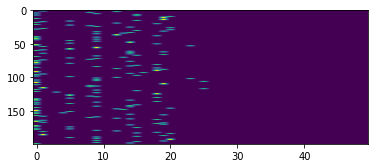

In [170]:
max_index = np.argmax(yhat, axis=1)
yhat[np.arange(yhat.shape[0]), max_index] = 1
yhat[yhat != 1] = 0
plt.imshow(yhat, aspect=0.1)

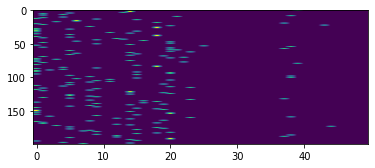

In [171]:
# plot next_char_train, with a good aspect ratio
plt.imshow(next_char_test, aspect=0.1)

In [172]:
yhat_train = kernel(X_train_enc, X_train_enc) @ alpha_hat

(next_char_train.argmax(axis=1) == yhat_train.argmax(axis=1)).mean()

0.97

In [173]:
def generate_text_kernel(kernel, alpha_hat, X, z, length=16):
    text = []
    for i in range(length):
        yhat = kernel(X, z) @ alpha_hat
        # decode the text
        text.append([reverse_vocab[y] for y in np.argmax(yhat, axis=1)])
        # move the window forward
        X = np.concatenate([X[:, len(train_vocab):], yhat], axis=1)
    
    transpose = list(zip(*text))
    return transpose

In [174]:
generated_test = generate_text_kernel(kernel, alpha_hat, X_test_enc, X_train_enc, length=CONTEXT_SIZE-CONTEXT_SPLIT_SIZE)

In [175]:
list(map(lambda x: "".join(x), generated_test))

['n  hir  isasir l',
 'an  e seo lt ia ',
 'las eg a oeeeoho',
 'h tnr mdnd st on',
 ' netnleee asaner',
 'ia  tna  iontraw',
 'onhesen nedeetoe',
 '  ais edi iois a',
 'o oii nwohe  heh',
 'tiaan  ea o e an',
 's it aotee  tise',
 's s rit a  idofo',
 '   io oia iieore',
 'ssoahy h  easlin',
 'soaes e ao reoto',
 'oior  ohtoeo hi ',
 'enesefo eirn   s',
 'aan tlreftn fnr ',
 ' id  oaeo noslet',
 'lsoeiiean  e i r',
 'rna oiranh serel',
 ' s, nthe tr et, ',
 'eeeonh e dtae te',
 'he i eoln hlrera',
 'irl t s ih e nom',
 'n, hoa eo en  f ',
 'ten  ioe eeie ri',
 'aanri os hieotrh',
 ' nts eerieod e e',
 't n t e.enr  oih',
 'oh  t senree e t',
 'ser eo riie iie ',
 'in ar   ooasorne',
 'nei.siie  ogna t',
 'm ts enhe  c  r ',
 'i tos p i  eeeoe',
 'l in s  iraherat',
 'llraot  rorl soh',
 'r o haon ahdr e ',
 ' t noaters  rese',
 'in  imeot  a itn',
 ' iai ns wiiooa h',
 '  oaiil ai seaoe',
 'ia dorwod eoomrn',
 ' irahdrs eh ooee',
 'e  hh  rei e ie ',
 'ieh m t  oo lne ',
 'nt o ro le 

In [202]:
reshaped_y_test = y_test_enc.reshape(-1, CONTEXT_SIZE-CONTEXT_SPLIT_SIZE,len(train_vocab))

y_test_text = ["".join([reverse_vocab[np.argmax(y)] for y in y_test]) for y_test in reshaped_y_test]

len(y_test_text)

200

In [206]:
evaluate(y_test_text, generated_test)

{'bleu2': 0.1678184606665611, 'perplexity': 10.069915360145755}

## RFM

In [148]:
alpha, M, _ = train_rfm(X_train_enc, next_char_train, L=48)

/home/arunavgupta/Documents/UCSD/ml-theory-capstone/src/utils.py:103: RuntimeWarning: divide by zero encountered in true_divide
  K = K / dist


In [149]:
y_train_pred = utils.K_M(X_train_enc, X_train_enc, M, L=48) @ alpha

In [150]:
utils.mse(y_train_pred, next_char_train)


6.714556775372001e-05

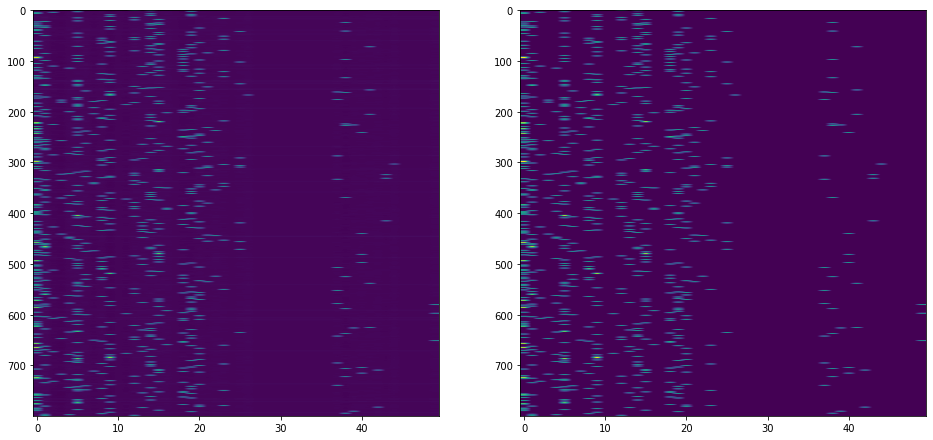

In [151]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 9))
ar = (y_train_pred.shape[1]/y_train_pred.shape[0])
ax[0].imshow(utils.softmax(y_train_pred, axis=1), aspect=ar)
ax[1].imshow(next_char_train, aspect=ar)

In [152]:
y_test_pred = utils.K_M(X_test_enc, X_train_enc, M, L=24) @ alpha

In [153]:
utils.mse(y_test_pred, next_char_test)

0.03375590151557867

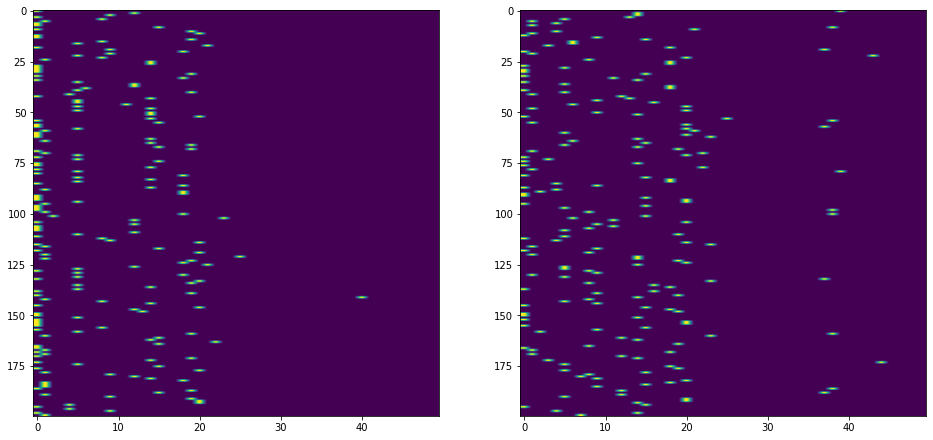

In [154]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 9))
ar = (y_test_pred.shape[1]/y_test_pred.shape[0])
y_test_argmax_ohc = np.eye(len(train_vocab))[y_test_pred.argmax(axis=1)]
ax[0].imshow(y_test_argmax_ohc, aspect=ar)
ax[1].imshow(next_char_test, aspect=ar)

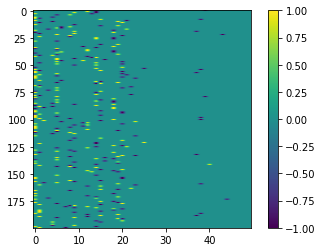

In [155]:
plt.imshow(y_test_argmax_ohc - next_char_test, aspect=ar)
plt.colorbar()

In [156]:
from functools import partial

In [157]:
kernel_rfm = partial(utils.K_M, M=M, L=24)

gen_test_rfm = generate_text_kernel(kernel_rfm, alpha, X_test_enc, X_train_enc, length=CONTEXT_SIZE-CONTEXT_SPLIT_SIZE)

In [207]:
evaluate(y_test_text, gen_test_rfm)

{'bleu2': 0.17520472487861702, 'perplexity': 9.127606369824862}

In [159]:
list(map(lambda x: "".join(x), gen_test_rfm))

[' a figo l a mrnl',
 'ln  pnnen e  ian',
 'ile en a se eand',
 ' atnioad dtse ca',
 'hn tale ryamen a',
 'ai itna  t n ra ',
 ' a erenaneme.ooe',
 ' aaislea ri in a',
 'onh sialle n  iy',
 ' hi ma ean  n al',
 's c alon e emene',
 'tas ne   ae m no',
 ' n rl rmormmenee',
 ' sor  ou aoas nn',
 's and  orl a ses',
 'hion aa tano har',
 'er ree teine l s',
 'u hes neit ef a ',
 ' in  oaa ayon  c',
 'i  an lan re ill',
 'r a oila mesn al',
 'it  mar.a’n tin ',
 'eneon hern  e pe',
 'he  srelha rdeya',
 'arl s s i  aan m',
 'n efor bfene  fr',
 'n os ret  icn ar',
 ' mor  as ainatne',
 ' nes anr mrd mhe',
 ' er iee eni emif',
 ' ta   wenrc  ere',
 'se  mo rrh  mir ',
 ' n aa a nsanernm',
 'rerly d ao aseam',
 ' ha ian are  na ',
 'e aos sor  ereoe',
 'l  n  s le her t',
 'll aa  ana lanom',
 'frt ma dianen e ',
 'e anoa neh oreno',
 'sna  orla os men',
 'difh n  fd  oa e',
 '   afil ai  eao ',
 'nen iowon hoonr ',
 'eiea dose e oa e',
 'er g,sarea e in ',
 'ked f s sen an t',
 'etes ao oa 

In [208]:
# get train and test accuracy
train_acc = (next_char_train.argmax(axis=1) == y_train_pred.argmax(axis=1)).mean()
test_acc = (next_char_test.argmax(axis=1) == y_test_pred.argmax(axis=1)).mean()

print(f"Train accuracy: {train_acc:.2f}")
print(f"Test accuracy: {test_acc:.2f}")

Train accuracy: 0.97
Test accuracy: 0.16
